# Import Required libraries

In [1]:
# Import Basic Packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import warnings
warnings.filterwarnings("ignore")

# sklearn packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                             confusion_matrix)

# tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Rescaling,
    Dense,
    Conv2D, 
    MaxPooling2D, 
    BatchNormalization, 
    Flatten
)
from tensorflow.keras.optimizers import (
    Adam, 
    RMSprop
)
from tensorflow.keras.losses import (
    SparseCategoricalCrossentropy, 
    CategoricalCrossentropy
)
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ModelCheckpoint
)

# Load the Dataset

In [2]:
IMAGE_DIR = "/Users/kavisanthoshkumar/Downloads/Sheep_Classification_Images/"
CSV_PATH = "/Users/kavisanthoshkumar/Downloads/Sheep_Classification_Images/train_labels.csv"

In [3]:
#### Read the CSV file using pandas
label_dataset = pd.read_csv(CSV_PATH)

#### Encode the values of the label
le = LabelEncoder()
le.fit(label_dataset["label"].values)
label_dataset["label_Encoded"] = le.transform(label_dataset["label"])

#### Build the full Image Paths
label_dataset["filepath"] = label_dataset["filename"].apply(lambda x : os.path.join(IMAGE_DIR, x))

label_dataset.head(5)

,filename,label,label_Encoded,filepath
0,39d30b68.jpg,Naeimi,3,/Users/kavisanthoshkumar/Downloads/Sheep_Class...
1,4a9853bd.jpg,Goat,1,/Users/kavisanthoshkumar/Downloads/Sheep_Class...
2,d88facaa.jpg,Roman,5,/Users/kavisanthoshkumar/Downloads/Sheep_Class...
3,a3f4f4af.jpg,Roman,5,/Users/kavisanthoshkumar/Downloads/Sheep_Class...
4,16b31730.jpg,Naeimi,3,/Users/kavisanthoshkumar/Downloads/Sheep_Class...


In [ ]:
pd.DataFrame({"labels":le.classes_, "Encoded_labels":le.transform(le.classes_)})

,labels,Encoded_labels
0,Barbari,0
1,Goat,1
2,Harri,2
3,Naeimi,3
4,Najdi,4
5,Roman,5
6,Sawakni,6


# Split the dataset into train and validation

In [5]:
X_train, X_val = train_test_split(label_dataset, 
                 train_size = 0.80, 
                 stratify= label_dataset['label']) 
# when we specify the stratify using class labels, then it gets split into stratified fashion

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")

Shape of X_train: (545, 4)
Shape of X_val: (137, 4)


In [6]:
X_test = pd.DataFrame({"filename": os.listdir(IMAGE_DIR+"test/")})
print(f"Shape of X_test: {X_test.shape}")

Shape of X_test: (144, 1)


# ImageData Generator

#### 1. TrainDataGenerator

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range = 20, 
    width_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True, 
    vertical_flip = True
)

# flow from dataframe 
train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    directory = IMAGE_DIR+str("train/"),
    x_col = "filename",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224, 224),
    batch_size = 32
)

Found 545 validated image filenames belonging to 7 classes.


#### 2. ValidationDataGenerator

In [8]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = X_val, 
    directory = IMAGE_DIR+"train/",
    x_col = "filename",
    y_col = "label",
    class_model = "categorical",
    target_size = (224, 224),
    batch_size = 32,
)

Found 137 validated image filenames belonging to 7 classes.


#### 3. TestDataGenerator

In [9]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe = X_test,
    directory = IMAGE_DIR + "test/",
    x_col = "filename",
    y_col = None,
    class_mode = None,
    target_size = (224, 224),
    batch_size = 32
)

Found 144 validated image filenames.


# Modelling

#### Model Architecture

In [ ]:
class CNNModel(Model):

    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        # layer 1
        self.conv_layer_1 = Conv2D(filters = 64, kernel_size = 3, strides =1, activation = 'relu')
        self.conv_layer_2 = Conv2D(filters = 128, kernel_size = 3, strides =1, activation = 'relu')
        self.conv_layer_3 = Conv2D(filters = 128, kernel_size = 3, strides =1, activation = 'relu')

        # BatchNormalization
        self.batch_1 = BatchNormalization(axis = -1)
        self.batch_2 = BatchNormalization(axis = -1)
        self.batch_3 = BatchNormalization(axis = -1)

        # MaxPooling layer
        self.pooling = MaxPooling2D(pool_size = (3, 3))
        
        # Dense layer
        self.dense_layer_1 = Dense(units = 256, activation ="leaky_relu")
        self.dense_layer_2 = Dense(units = 256, activation ="leaky_relu")
        self.dense_layer_3 = Dense(units = 128, activation ="leaky_relu") 
        self.dense_layer_4 = Dense(units = 64, activation ="leaky_relu")

        # Flatten
        self.flatten = Flatten()

        # Output layer 
        self.out = Dense(units = num_classes, activation ="softmax")


    def call(self, inputs):
        
        # First Convolution Network
        x= self.conv_layer_1(inputs)
        x= self.batch_1(x, training = True)
        x= self.pooling(x)
        

        # Second Convolution Network
        x= self.conv_layer_2(x)
        x= self.batch_2(x, training = True)
        x= self.pooling(x)


        # Second Convolution Network
        x= self.conv_layer_3(x)
        x= self.batch_3(x, training = True)
        x= self.pooling(x)

        # Flatten
        x = self.flatten(x)

        # Dense layers
        x = self.dense_layer_1(x) 
        x = self.dense_layer_2(x)
        x = self.dense_layer_3(x)
        x = self.dense_layer_4(x)

        return self.out(x)
    
cnn_basic_model = CNNModel(num_classes=7)

#### Compile Model

In [11]:
cnn_basic_model.compile(optimizer= Adam(), 
                        loss = CategoricalCrossentropy(),
                        metrics = ['f1_score'],
                        )

2025-06-21 20:52:58.414359: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-06-21 20:52:58.414381: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-06-21 20:52:58.414386: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1750557178.414396 7970486 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750557178.414411 7970486 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Callbacks

In [22]:
earlystopping_callback = EarlyStopping(
    monitor = "val_loss",
    patience = 5, 
    mode = "min",
    restore_best_weights = True, 
    verbose = 1
)

model_check_point_callback = ModelCheckpoint(
    filepath = "./artifacts/cnn_basic_model.keras",
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, 
)

callbacks = [earlystopping_callback, model_check_point_callback]

#### Model Training

In [24]:
history = cnn_basic_model.fit(train_generator, 
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = callbacks)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - f1_score: 0.5868 - loss: 0.9517 - val_f1_score: 0.5597 - val_loss: 1.0090
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - f1_score: 0.5975 - loss: 0.8919 - val_f1_score: 0.5493 - val_loss: 0.9798
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - f1_score: 0.6541 - loss: 0.7796 - val_f1_score: 0.6031 - val_loss: 1.0339
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - f1_score: 0.6771 - loss: 0.7798 - val_f1_score: 0.5625 - val_loss: 1.0808
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - f1_score: 0.6476 - loss: 0.7545 - val_f1_score: 0.5420 - val_loss: 1.2891
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - f1_score: 0.6284 - loss: 0.8030 - val_f1_score: 0.5453 - val_loss: 1.0620
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - f1_score: 0.6498 - loss: 0.7567 - val_f1_score: 0.5287 - val_loss: 1.2258
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [46]:
cnn_basic_model.summary()

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,812,119 (22.17 MB)

 Trainable params: 1,937,159 (7.39 MB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 3,874,320 (14.78 MB)

#### Model loss

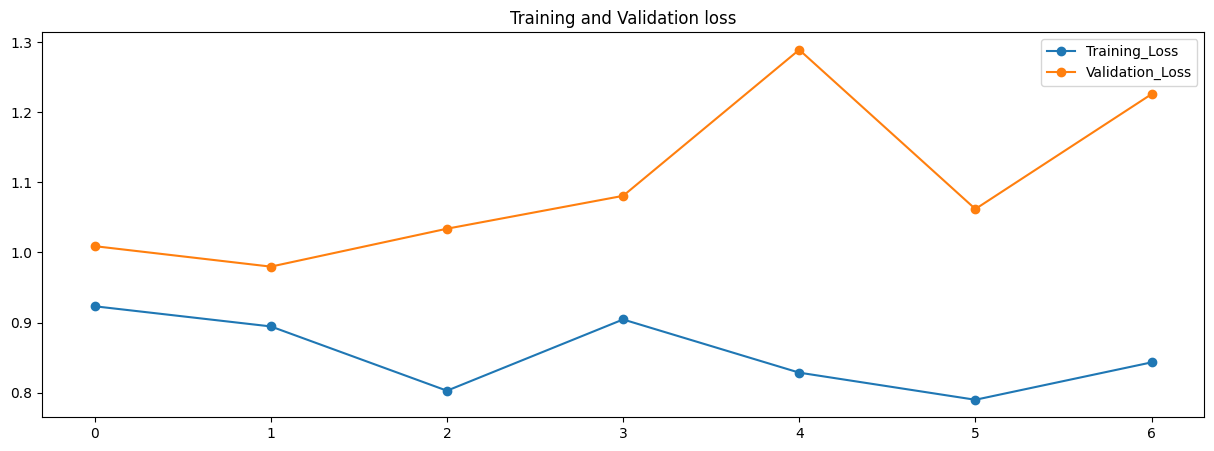

In [62]:
plt.figure(figsize= (15, 5))
plt.plot(history.history["loss"], 'o-',label = "Training_Loss")
plt.plot(history.history["val_loss"], 'o-',label = "Validation_Loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [57]:
history.history.keys()

dict_keys(['f1_score', 'loss', 'val_f1_score', 'val_loss'])

#### Predictions

In [ ]:
# Generating Predictions 
predictions = cnn_basic_model.predict(test_generator, verbose = 0)
predictions = np.argmax(predictions, axis = 1)

# Submission format
X_test["label"] = predictions
class_indices = {v:k for k, v in train_generator.class_indices.items()}
X_test["label"] = X_test["label"].map(class_indices)

In [44]:
X_test.to_csv("./data/output/Submission.csv",index = False)